This script is a part of a post about how to enhance the spatial resolution of Himawari Satellite Data

https://ulil-hidayat.github.io/2023/12/17/sharpening-res.html

In [1]:
#This method, known as Additive Template Sharpening (ATS), is a suitable sharpening technique designed for Himawari 8/9, developed by Yamazaki (2021). For detailed information, refer to the paper:
#https://www.jstage.jst.go.jp/article/sola/17/0/17_2021-039/_article/-char/en

#Import module
import numpy as np
from PIL import Image
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
#open data
PATH = '/media/evan/A8242CC6242C9978/desember/'
band5 = PATH+'b5.nc'
band_5 = xr.open_dataset(band5)

band3 = PATH+'b3.nc'
band_3 = xr.open_dataset(band3)


band4 = PATH+'b4.nc'
band_4 = xr.open_dataset(band4)



In [8]:
# Function to sharpen "multispectral_data" by "template" via Additive Template Sharpening.
# The shape of "template" must be divisible by "multispectral_data".
def sharpen_ATS(data1, data2):
    data1 = xr.open_dataset(data1)
    data2 = xr.open_dataset(data2)
    multispectral_data = data1["albedo"] #albedo is referes to variable names
    template = data2["albedo"]

    # Internal function to resize array "data" into shape (ny, nx)
    def lanczos_resize(data, nx, ny):
        img_src = Image.fromarray(data.astype(np.float32))
        return np.asarray(img_src.resize(size=(nx, ny), resample=Image.LANCZOS))
    
    multispectral_data = multispectral_data.values  # Convert xarray DataArray to NumPy array
    template = template.values  # Convert xarray DataArray to NumPy array

    ny, nx = template.shape
    #print(template.shape)
    ny2, nx2 = multispectral_data.shape
    #print(multispectral_data.shape)
    r = ny // ny2
    if nx2*r != nx or ny2*r != ny:
        raise ValueError('The shape of "template" must be divisible by that of "multispectral_data".')

    # Normalize
    template_norm = np.nanstd(multispectral_data) / np.nanstd(template) * template
    
    # rxr-average
    small_template = np.average(template_norm.reshape(ny2,r, nx2,r), axis=(1,3))
    
    # Upsample low-res differential field
    diff_hires = lanczos_resize(multispectral_data-small_template, nx, ny)
        
    # Instead of returning only the processed values, retain the coordinates
    sharpened_data = template_norm + diff_hires
    
    # Create a new DataArray with the sharpened data and coordinate information
    sharpened_da = xr.DataArray(
        sharpened_data,
        coords={'latitude': data2['latitude'], 'longitude': data2['longitude']},
        dims=('latitude', 'longitude'),
        name='sharpened_albedo'  # Assign a name to the variable
    )
    
    return sharpened_da

In [10]:
#run the process
b4_hres = sharpen_ATS(band4, band3)
b5_hres = sharpen_ATS(band5, band3)

b4_hres.to_netcdf("/media/evan/A8242CC6242C9978/b4_hres.nc") #for band4
b5_hres.to_netcdf("/media/evan/A8242CC6242C9978/b5_hres.nc") #for band5

<xarray.DataArray 'sharpened_albedo' (latitude: 2000, longitude: 5500)>
array([[0.18265188, 0.17481416, 0.16072056, ..., 0.01580471, 0.01467938,
        0.01401158],
       [0.11954947, 0.11810124, 0.13553533, ..., 0.01765401, 0.01738489,
        0.02362562],
       [0.11514954, 0.12244041, 0.08954415, ..., 0.01507515, 0.01626755,
        0.0231527 ],
       ...,
       [0.02979015, 0.02955617, 0.02537061, ..., 0.3062804 , 0.2934811 ,
        0.28853863],
       [0.02391234, 0.02434077, 0.0259026 , ..., 0.29930404, 0.27636868,
        0.35562146],
       [0.0160819 , 0.01702378, 0.02208445, ..., 0.25978136, 0.21798614,
        0.2707982 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 10.0 9.995 9.99 9.985 ... 0.015 0.01 0.005
  * longitude  (longitude) float32 90.0 90.0 90.01 90.01 ... 117.5 117.5 117.5


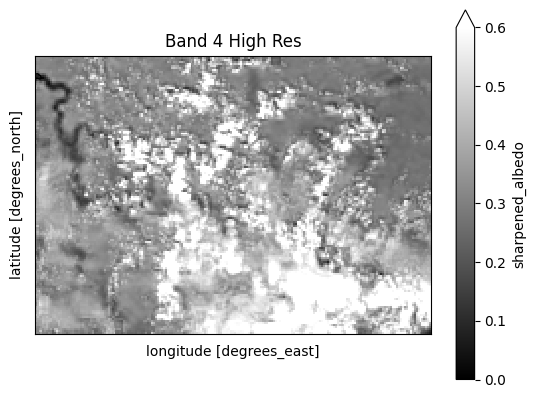

In [11]:
#Displaying the data
#band_4 
PATH = '/media/evan/A8242CC6242C9978/desember/'
data1 = b4_hres
data2 = data1
print(data2)
min_longitude = 111.2
max_longitude = 112.2
min_latitude = 1.0
max_latitude = 1.7

#crop the data
longitude_indices = (data2.longitude >= min_longitude) & (data2.longitude <= max_longitude)
latitude_indices = (data2.latitude >= min_latitude) & (data2.latitude <= max_latitude)


data2 = data2.sel(longitude=longitude_indices, latitude=latitude_indices) #now crop the data
below,above,left,right = min_latitude, max_latitude, min_longitude, max_longitude #AOI
m = Basemap(projection='cyl',llcrnrlat=below,llcrnrlon=left,urcrnrlat=above,urcrnrlon=right,resolution='h',)
m.drawcoastlines(color='black')

data2.plot(cmap='gray', vmin=0, vmax=0.6)
plt.title('Band 4 High Res')
plt.show()

<xarray.DataArray 'sharpened_albedo' (latitude: 2000, longitude: 5500)>
array([[0.10745738, 0.11085069, 0.11393151, ..., 0.01256495, 0.01267301,
        0.01254175],
       [0.08409552, 0.08772639, 0.10050444, ..., 0.01177949, 0.01185306,
        0.01461811],
       [0.08851486, 0.09247994, 0.07676569, ..., 0.00794633, 0.0079485 ,
        0.01065623],
       ...,
       [0.0182812 , 0.01842055, 0.01690767, ..., 0.15951481, 0.14334838,
        0.13587508],
       [0.01570848, 0.0158522 , 0.01639283, ..., 0.15684539, 0.15094252,
        0.18751702],
       [0.01216889, 0.01231407, 0.01402665, ..., 0.14169678, 0.13741861,
        0.16654456]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 10.0 9.995 9.99 9.985 ... 0.015 0.01 0.005
  * longitude  (longitude) float32 90.0 90.0 90.01 90.01 ... 117.5 117.5 117.5


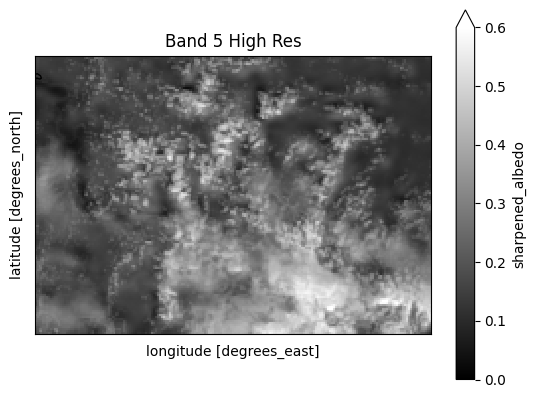

In [13]:
#band_5 
PATH = '/media/evan/A8242CC6242C9978/desember/'
data1 = b5_hres
data2 = data1
print(data2)
min_longitude = 111.2
max_longitude = 112.2
min_latitude = 1.0
max_latitude = 1.7

#crop the data
longitude_indices = (data2.longitude >= min_longitude) & (data2.longitude <= max_longitude)
latitude_indices = (data2.latitude >= min_latitude) & (data2.latitude <= max_latitude)


data2 = data2.sel(longitude=longitude_indices, latitude=latitude_indices) #now crop the data
below,above,left,right = min_latitude, max_latitude, min_longitude, max_longitude #AOI
m = Basemap(projection='cyl',llcrnrlat=below,llcrnrlon=left,urcrnrlat=above,urcrnrlon=right,resolution='h',)
m.drawcoastlines(color='black')

data2.plot(cmap='gray', vmin=0, vmax=0.6)
plt.title('Band 5 High Res')
plt.show()

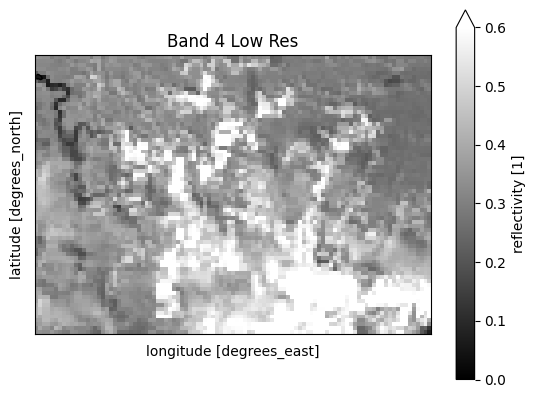

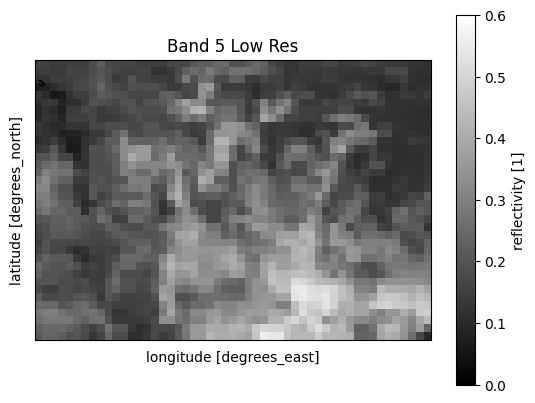

In [14]:
#Band 4 and 5 Low Res
PATH = '/media/evan/A8242CC6242C9978/desember/'
def display_data(datas, PATH, title, cmap='Blues'):

    data = datas
    data= PATH+data

    data1 = xr.open_dataset(data)
    data2 = data1["albedo"]
    #print(data2.shape)


    #print(data1.variables)
    min_longitude = 111.2
    max_longitude = 112.2
    min_latitude = 1.0
    max_latitude = 1.7

    #crop
    longitude_indices = (data2.longitude >= min_longitude) & (data2.longitude <= max_longitude)
    latitude_indices = (data2.latitude >= min_latitude) & (data2.latitude <= max_latitude)

    data2 = data2.sel(longitude=longitude_indices, latitude=latitude_indices) #now crop the data
    below,above,left,right = min_latitude, max_latitude, min_longitude, max_longitude #AOI
    m = Basemap(projection='cyl',llcrnrlat=below,llcrnrlon=left,urcrnrlat=above,urcrnrlon=right,resolution='h',)
    m.drawcoastlines(color='black')

    data2.plot(cmap=cmap, vmin=0, vmax=0.6)
    plt.title(title)
    plt.show()

a = display_data('b4.nc', PATH, 'Band 4 Low Res', cmap='gray')
b = display_data('b5.nc', PATH, 'Band 5 Low Res', cmap='gray')